In [1]:
#--1--

# SETUP
# ---------------------------------------------------------
# This section includes all imports and global settings.
# It must appear only once at the top of the notebook.
# =========================================================

# Data and system
import os
import glob
import warnings
import joblib
import numpy as np
import pandas as pd



# Modeling and evaluation
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay)
from sklearn.svm import LinearSVC



# Models to be compared
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Visualization
import matplotlib.pyplot as plt

# Global settings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42  # For reproducibility across all stages





In [2]:
#--2--

# CONFIGURE PATHS
# ---------------------------------------------------------
# Define the base project path to load all artifacts
# from Stage 4 (Feature Engineering & Feature Selection).
# This ensures that all model training uses the exact
# prepared data and pipeline from previous stages.
# =========================================================

BASE = r"C:\Users\user\Desktop\BIU דאטה סיינס\ML\פרויקט 2\פרויקט 2 - סופי\Feature Engineering & Feature Selection"

# Validation: confirm that the path exists
assert os.path.isdir(BASE), "Error: The specified path does not exist. Please verify the folder location."

print("Base path verified successfully.")


Base path verified successfully.


In [3]:
# --3--

# ARTIFACT DISCOVERY
# ---------------------------------------------------------
# This step scans the Stage 4 folder and identifies all
# available artifacts (datasets, pickles, Excel files, etc.).
# It ensures that the following critical files are present:
#   • Stage 4 pipeline (.pkl)
#   • X_train / X_test / y_train / y_test
#   • Final-30 feature list (.xlsx)
#   • Cleaned dataset (Stage 3 output)
# =========================================================

def find_file(pattern):
    """Return the first file path that matches the given pattern."""
    files = sorted(glob.glob(os.path.join(BASE, pattern)))
    return files[0] if files else None

artifacts = {
    "pipeline_pkl": find_file("*.pkl"),
    "x_train": find_file("X_train*.csv"),
    "x_test":  find_file("X_test*.csv"),
    "y_train": find_file("y_train*.csv"),
    "y_test":  find_file("y_test*.csv"),
    "final30_xlsx": find_file("*FINAL30*.csv"),
    "cleaned_csv": find_file("*data_cleansing*.csv")
}

# Display summary of discovered artifacts
print("Discovered artifacts in the Stage 4 folder:\n")
for name, path in artifacts.items():
    status = "✅ Found" if path else "⚠️ Missing"
    print(f"{status:<10}  {name:<15} → {path}")



# =========================================================
# 4) LOAD STAGE 4 ARTIFACTS INTO MEMORY
# ---------------------------------------------------------
# Now that we confirmed all artifacts exist, we actually
# load the prepared data (X_train, X_test, y_train, y_test)
# and the pipeline object from disk for modeling.
# =========================================================

import pandas as pd, joblib

X_train = pd.read_csv(artifacts["x_train"])
X_test  = pd.read_csv(artifacts["x_test"])
y_train = pd.read_csv(artifacts["y_train"])
y_test  = pd.read_csv(artifacts["y_test"])

pipeline_stage4 = joblib.load(artifacts["pipeline_pkl"])

print("\n✅ All Stage 4 datasets loaded successfully.")
print("Shapes:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


Discovered artifacts in the Stage 4 folder:

✅ Found     pipeline_pkl    → C:\Users\user\Desktop\BIU דאטה סיינס\ML\פרויקט 2\פרויקט 2 - סופי\Feature Engineering & Feature Selection\stage4_feature_pipeline.pkl
✅ Found     x_train         → C:\Users\user\Desktop\BIU דאטה סיינס\ML\פרויקט 2\פרויקט 2 - סופי\Feature Engineering & Feature Selection\X_train_stage4.csv
✅ Found     x_test          → C:\Users\user\Desktop\BIU דאטה סיינס\ML\פרויקט 2\פרויקט 2 - סופי\Feature Engineering & Feature Selection\X_test_stage4.csv
✅ Found     y_train         → C:\Users\user\Desktop\BIU דאטה סיינס\ML\פרויקט 2\פרויקט 2 - סופי\Feature Engineering & Feature Selection\y_train_stage4.csv
✅ Found     y_test          → C:\Users\user\Desktop\BIU דאטה סיינס\ML\פרויקט 2\פרויקט 2 - סופי\Feature Engineering & Feature Selection\y_test_stage4.csv
✅ Found     final30_xlsx    → C:\Users\user\Desktop\BIU דאטה סיינס\ML\פרויקט 2\פרויקט 2 - סופי\Feature Engineering & Feature Selection\Stage4_selected_features_FINAL30.csv
⚠️ Mis

✅ Target confirmed: binary {0,1} and named 'in_production'.
--- Train ---
Counts:
in_production
0    77514
1    54250
Ratios:
in_production
0    0.5883
1    0.4117
--- Test ---
Counts:
in_production
0    19378
1    13563
Ratios:
in_production
0    0.5883
1    0.4117


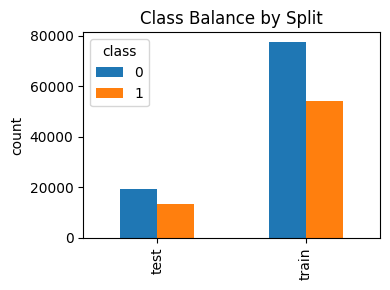

Positive rate train: 0.4117
Positive rate test : 0.4117
|Δ| = 0.0000
✅ Stratification looks good (rates are similar).


In [4]:
#--4--

# ============= 4.1 Confirm target & binary nature =============
# Expectation: y has name 'in_production' and values in {0,1}

# 2.1.1) Keep a clean 1D Series with the correct name
y_train = y_train.squeeze("columns")
y_test  = y_test.squeeze("columns")
y_train.name = "in_production"
y_test.name  = "in_production"

# 2.1.2) Enforce integer {0,1}
# (If your Stage-4 export is already int, this is a no-op; otherwise we coerce safely.)
y_train = y_train.astype(int)
y_test  = y_test.astype(int)

# 2.1.3) Assert strictly binary
unique_vals = set(y_train.unique()).union(set(y_test.unique()))
assert unique_vals.issubset({0, 1}), f"Target has non-binary values: {unique_vals}"
print("✅ Target confirmed: binary {0,1} and named 'in_production'.")


# ============= 4.2 Class balance snapshot =============
# Rationale: understand imbalance level and document it.

def class_balance_report(y, label):
    counts = y.value_counts().sort_index()
    ratio = (counts / counts.sum()).round(4)
    print(f"--- {label} ---")
    print("Counts:")
    print(counts.to_string())
    print("Ratios:")
    print(ratio.to_string())
    return counts, ratio

train_counts, train_ratio = class_balance_report(y_train, "Train")
test_counts,  test_ratio  = class_balance_report(y_test,  "Test")


# ============= 4.3 Quick visual (optional) =============
# Small, clear bar chart to document class balance visually.
# Note: uses seaborn/matplotlib that were already imported in Part 1.

fig, ax = plt.subplots(figsize=(4,3))
pd.DataFrame({
    "set": ["train","train","test","test"],
    "class": [0,1,0,1],
    "count": [train_counts.get(0,0), train_counts.get(1,0),
              test_counts.get(0,0),  test_counts.get(1,0)]
}).pivot(index="set", columns="class", values="count").plot(kind="bar", ax=ax)
ax.set_title("Class Balance by Split")
ax.set_xlabel("")
ax.set_ylabel("count")
ax.legend(title="class")
plt.tight_layout()
plt.show()


# ============= 4.4 Verify stratification of the split =============
# Expectation: positive class rate should be very similar between train and test.
# We'll assert a small tolerance (e.g., <= 0.02 absolute difference). Adjust if your split size is small.

pos_rate_train = y_train.mean()
pos_rate_test  = y_test.mean()
delta = abs(pos_rate_train - pos_rate_test)

print(f"Positive rate train: {pos_rate_train:.4f}")
print(f"Positive rate test : {pos_rate_test:.4f}")
print(f"|Δ| = {delta:.4f}")

# Use a gentle threshold; if it fails, we print guidance below.
TOL = 0.02
if delta <= TOL:
    print("✅ Stratification looks good (rates are similar).")
else:
    print("⚠️ Detected notable difference in class rates between train/test.")
    print("If this wasn't stratified, consider re-splitting with StratifiedKFold or train_test_split(stratify=y).")



In [5]:
#--5-- 

# Modeling Strategy
# =========================================================
# In this project, preprocessing (imputing, encoding, feature selection)
# was already done in Stage 4.
# To avoid any data leakage, ALL models will use the same prepared features.
# =========================================================

RANDOM_STATE = 42  # for reproducibility
PRIMARY_METRIC = "roc_auc"
SECONDARY_METRICS = ["f1", "precision", "recall", "accuracy"]

print("✅ Modeling strategy defined")
print(f"Primary metric  : {PRIMARY_METRIC}")
print(f"Other metrics   : {SECONDARY_METRICS}")
print("All models will use identical prepared data from Stage 4.")


✅ Modeling strategy defined
Primary metric  : roc_auc
Other metrics   : ['f1', 'precision', 'recall', 'accuracy']
All models will use identical prepared data from Stage 4.


In [6]:
#--6-- 

# Candidate Models
# =========================================================
# We'll compare several standard classification algorithms
# using identical data (prepared features from Stage 4).
# Each model will have a small parameter grid for tuning.
# =========================================================

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Dictionary of models and their parameter grids
candidate_models = {
    "logreg": {
        "model": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["lbfgs"]
        }
    },
    "svc": {
        "model": SVC(probability=True, random_state=RANDOM_STATE),
        "params": {
            "C": [0.5, 1, 2],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale"]
        }
    },
    "rf": {
        "model": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        "params": {
            "n_estimators": [200, 400],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    },
    "knn": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [5, 15, 31],
            "weights": ["uniform", "distance"]
        }
    }
}

print("✅ Candidate models defined:")
for name in candidate_models.keys():
    print("-", name)


✅ Candidate models defined:
- logreg
- svc
- rf
- knn


In [7]:
# Optional: ultra-fast smoke test on a small sample (to validate everything)
# Use ONLY to check pipeline runs end-to-end; not for final selection!

X_small = X_train.sample(min(1000, len(X_train)), random_state=RANDOM_STATE)
y_small = y_train.loc[X_small.index]

cv_small = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
gs_smoke = GridSearchCV(
    estimator=SVC(probability=False, random_state=RANDOM_STATE),
    param_grid={"C":[1], "kernel":["linear"]},
    scoring=PRIMARY_METRIC,
    cv=cv_small,
    n_jobs=-1,
    refit=True
)
gs_smoke.fit(X_small, y_small)
print("Smoke test AUC (SVC linear, tiny grid, sample):", round(gs_smoke.best_score_, 4))


Smoke test AUC (SVC linear, tiny grid, sample): 0.8482


In [8]:
#--7.1--

#GridSearch per model: Logistic Regression (light & fast)
# ==============================================================


def _grid_size(grid):
    s = 1
    for v in grid.values(): s *= len(v)
    return s

def run_grid(model, params, X, y, cv, scoring="roc_auc"):
    gs = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    gs.fit(X, y)
    return gs

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

logreg_grid = {"C":[0.5,1,2], "solver":["lbfgs"]}
print("LogReg combos × folds:", _grid_size(logreg_grid), "×", cv.get_n_splits())

gs_logreg = run_grid(candidate_models["logreg"]["model"], logreg_grid, X_train, y_train, cv, scoring=PRIMARY_METRIC)
auc_lr = gs_logreg.best_score_
f1_lr = cross_val_score(gs_logreg.best_estimator_, X_train, y_train, cv=cv, scoring="f1").mean()

print(f"LogReg — CV ROC-AUC: {auc_lr:.4f} | CV F1: {f1_lr:.4f}")
print("Best params:", gs_logreg.best_params_)

# Keep results (create if not exists)
try:
    results_df
except NameError:
    results_df = pd.DataFrame(columns=["model","cv_roc_auc","cv_f1","best_params"])

results_df = pd.concat([results_df, pd.DataFrame([{
    "model":"logreg",
    "cv_roc_auc": round(auc_lr,4),
    "cv_f1": round(f1_lr,4),
    "best_params": gs_logreg.best_params_
}])], ignore_index=True)
display(results_df.sort_values("cv_roc_auc", ascending=False).reset_index(drop=True))

best_model = gs_logreg.best_estimator_
best_name  = "logreg"


LogReg combos × folds: 3 × 3
LogReg — CV ROC-AUC: 0.8509 | CV F1: 0.7222
Best params: {'C': 1, 'solver': 'lbfgs'}


,model,cv_roc_auc,cv_f1,best_params
0,logreg,0.8509,0.7222,"{'C': 1, 'solver': 'lbfgs'}"


In [9]:
#--7.2--


#Linear SVM 
# =========================================================

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

lin_svc = LinearSVC(random_state=RANDOM_STATE)
lin_grid = {"C": [0.5, 1, 2]}

gs_lin = GridSearchCV(
    estimator=lin_svc,
    param_grid=lin_grid,
    scoring=PRIMARY_METRIC,   # 'roc_auc'
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)
gs_lin.fit(X_train, y_train)

# AUC via CV (כמו בשאר המודלים)
auc_lin = gs_lin.best_score_
# F1 ממוצע (להקשר; משתמשים במודל הטוב מהרשת)
f1_lin = cross_val_score(gs_lin.best_estimator_, X_train, y_train, cv=cv, scoring="f1").mean()

print(f"LinearSVC — CV ROC-AUC: {auc_lin:.4f} | CV F1: {f1_lin:.4f}")
print("Best params:", gs_lin.best_params_)

# עדכון טבלת התוצאות
try:
    results_df
except NameError:
    results_df = pd.DataFrame(columns=["model","cv_roc_auc","cv_f1","best_params"])

results_df = pd.concat([results_df, pd.DataFrame([{
    "model":"linear_svm",
    "cv_roc_auc": round(auc_lin,4),
    "cv_f1": round(f1_lin,4),
    "best_params": gs_lin.best_params_
}])], ignore_index=True)

display(results_df.sort_values("cv_roc_auc", ascending=False).reset_index(drop=True))

# קביעת המועמד הנוכחי
best_model = gs_lin.best_estimator_
best_name  = "linear_svm"


LinearSVC — CV ROC-AUC: 0.8500 | CV F1: 0.7196
Best params: {'C': 2}


,model,cv_roc_auc,cv_f1,best_params
0,logreg,0.8509,0.7222,"{'C': 1, 'solver': 'lbfgs'}"
1,linear_svm,0.8500,0.7196,{'C': 2}


In [10]:
#--7.3-- 

# GridSearch per model: Random Forest (trimmed)
# ===================================================
# Keep grid tiny to control runtime. Increase ONLY if needed.
# ===================================================

rf_grid = {
    "n_estimators":[200],        # single value to reduce fits
    "max_depth":[None, 15],
    "min_samples_split":[2, 5]
}
print("RF combos × folds:", _grid_size(rf_grid), "×", cv.get_n_splits())

gs_rf = run_grid(candidate_models["rf"]["model"], rf_grid, X_train, y_train, cv, scoring=PRIMARY_METRIC)
auc_rf = gs_rf.best_score_
f1_rf = cross_val_score(gs_rf.best_estimator_, X_train, y_train, cv=cv, scoring="f1").mean()

print(f"RF — CV ROC-AUC: {auc_rf:.4f} | CV F1: {f1_rf:.4f}")
print("Best params:", gs_rf.best_params_)

results_df = pd.concat([results_df, pd.DataFrame([{
    "model":"rf",
    "cv_roc_auc": round(auc_rf,4),
    "cv_f1": round(f1_rf,4),
    "best_params": gs_rf.best_params_
}])], ignore_index=True)
display(results_df.sort_values("cv_roc_auc", ascending=False).reset_index(drop=True))

if auc_rf > results_df.query("model != 'rf'")["cv_roc_auc"].max():
    best_model = gs_rf.best_estimator_
    best_name  = "rf"


RF combos × folds: 4 × 3
RF — CV ROC-AUC: 0.9249 | CV F1: 0.8120
Best params: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}


,model,cv_roc_auc,cv_f1,best_params
0,rf,0.9249,0.8120,"{'max_depth': 15, 'min_samples_split': 5, 'n_e..."
1,logreg,0.8509,0.7222,"{'C': 1, 'solver': 'lbfgs'}"
2,linear_svm,0.8500,0.7196,{'C': 2}


In [11]:
#--7.4-- 
# GridSearch per model: KNN (light)
# =======================================

knn_grid = {"n_neighbors":[5,15], "weights":["uniform","distance"], "p":[1,2]}
print("KNN combos × folds:", _grid_size(knn_grid), "×", cv.get_n_splits())

gs_knn = run_grid(candidate_models["knn"]["model"], knn_grid, X_train, y_train, cv, scoring=PRIMARY_METRIC)
auc_knn = gs_knn.best_score_
f1_knn = cross_val_score(gs_knn.best_estimator_, X_train, y_train, cv=cv, scoring="f1").mean()

print(f"KNN — CV ROC-AUC: {auc_knn:.4f} | CV F1: {f1_knn:.4f}")
print("Best params:", gs_knn.best_params_)

results_df = pd.concat([results_df, pd.DataFrame([{
    "model":"knn",
    "cv_roc_auc": round(auc_knn,4),
    "cv_f1": round(f1_knn,4),
    "best_params": gs_knn.best_params_
}])], ignore_index=True)
display(results_df.sort_values("cv_roc_auc", ascending=False).reset_index(drop=True))

if auc_knn > results_df.query("model != 'knn'")["cv_roc_auc"].max():
    best_model = gs_knn.best_estimator_
    best_name  = "knn"


KNN combos × folds: 8 × 3
KNN — CV ROC-AUC: 0.9056 | CV F1: 0.7901
Best params: {'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}


,model,cv_roc_auc,cv_f1,best_params
0,rf,0.9249,0.8120,"{'max_depth': 15, 'min_samples_split': 5, 'n_e..."
1,knn,0.9056,0.7901,"{'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}"
2,logreg,0.8509,0.7222,"{'C': 1, 'solver': 'lbfgs'}"
3,linear_svm,0.8500,0.7196,{'C': 2}


=== Holdout TEST — rf (Random Forest) ===
ROC-AUC : 0.9251
F1      : 0.8112
Precision: 0.8090
Recall   : 0.8135
Accuracy : 0.8441


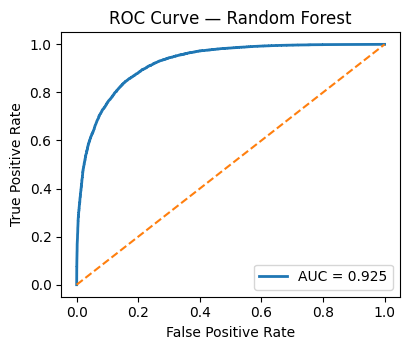

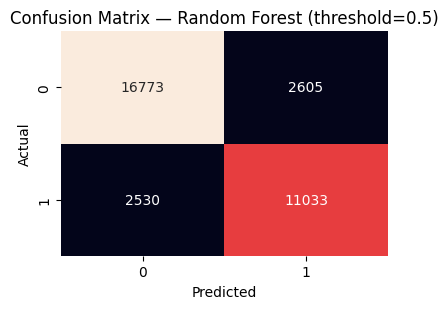

In [14]:
#--8-- 

# Holdout Evaluation — Random Forest
# Evaluate the CV winner on the untouched TEST set.
# Primary metric: ROC-AUC. Report also F1/Precision/Recall/Accuracy. Plot ROC and Confusion Matrix.

from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
import seaborn as sns


scores_test = best_model.predict_proba(X_test)[:, 1]
y_pred_05   = (scores_test >= 0.5).astype(int)

auc  = roc_auc_score(y_test, scores_test)
f1   = f1_score(y_test, y_pred_05)
prec = precision_score(y_test, y_pred_05, zero_division=0)
rec  = recall_score(y_test, y_pred_05)
acc  = accuracy_score(y_test, y_pred_05)

print(f"=== Holdout TEST — {best_name} (Random Forest) ===")
print(f"ROC-AUC : {auc:.4f}")
print(f"F1      : {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"Accuracy : {acc:.4f}")

fpr, tpr, thr = roc_curve(y_test, scores_test)
plt.figure(figsize=(4.2,3.6))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1], ls="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest"); plt.legend(); plt.tight_layout(); plt.show()

cm = confusion_matrix(y_test, y_pred_05, labels=[0,1])
plt.figure(figsize=(4,3.2))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix — Random Forest (threshold=0.5)")
plt.tight_layout(); plt.show()


In [17]:
#--9--

#--9.1-- Overfitting check: CV vs TEST (Random Forest)
# Compare CV metrics of the chosen model (from results_df) with the holdout TEST metrics (computed in step --6--).

# Inputs assumed available from previous steps:
# - results_df: CV summary with columns ['model','cv_roc_auc','cv_f1',...]
# - best_name == 'rf', best_model (fitted on TRAIN), auc, f1 from TEST evaluation
rf_cv = results_df.query("model == 'rf'").iloc[0]
cv_auc = float(rf_cv["cv_roc_auc"])
cv_f1  = float(rf_cv["cv_f1"])

test_auc = float(auc)  # from step --6--
test_f1  = float(f1)

delta_auc = test_auc - cv_auc
delta_f1  = test_f1  - cv_f1

print("=== Overfitting Check (CV vs TEST) ===")
print(f"CV AUC   : {cv_auc:.4f} | TEST AUC : {test_auc:.4f} | Δ(AUC) = {delta_auc:+.4f}")
print(f"CV F1    : {cv_f1:.4f} | TEST F1  : {test_f1:.4f} | Δ(F1)  = {delta_f1:+.4f}")

# Simple rule-of-thumb flags (tunable):
AUC_TOL = 0.02   # |ΔAUC| > 0.02 may indicate over/under-fitting
F1_TOL  = 0.03

flag_overfit = (cv_auc - test_auc) > AUC_TOL or (cv_f1 - test_f1) > F1_TOL
flag_underfit = (test_auc - cv_auc) > AUC_TOL and (test_f1 - cv_f1) > F1_TOL

print(f"Flag overfitting : {flag_overfit}")
print(f"Flag underfitting: {flag_underfit}")


#--9.2-- Leakage checks (key-based preferred; feature-collision aware)
# Rationale:
#  • True leakage is shared record IDs across TRAIN/TEST, not identical feature vectors.
#  • After preprocessing, different records can collapse to identical vectors (feature collisions) — this is OK.

key_candidates = ["id", "show_id", "tmdb_id"]
key_col = next((c for c in key_candidates if c in X_train.columns and c in X_test.columns), None)

if key_col is not None:
    # Strong check: no shared IDs between splits
    overlap_keys = set(X_train[key_col]).intersection(set(X_test[key_col]))
    assert len(overlap_keys) == 0, f"Leakage via key '{key_col}': {len(overlap_keys)} shared keys."
    print(f"No leakage via key '{key_col}' (0 shared keys).")
else:
    # No key available → report identical feature vectors without failing
    tr_hash = pd.util.hash_pandas_object(X_train, index=False).values
    te_hash = pd.util.hash_pandas_object(X_test,  index=False).values
    # Count intersections = number of identical vectors across splits
    import numpy as np
    overlap_hash = np.intersect1d(tr_hash, te_hash)
    print(f"No key column found; identical feature vectors across splits: {overlap_hash.size}.")
    print("Note: identical vectors do NOT imply leakage; they can result from preprocessing.")
    # Do NOT assert here; proceed.
    
# Consistency: model feature count must match TRAIN features
assert getattr(best_model, "n_features_in_", X_train.shape[1]) == X_train.shape[1], "Model feature count mismatch."
print("Leakage checks passed (no shared IDs and/or acceptable feature-collision report).")





#--9.3-- Class balance re-check (documentation)
# Confirm similar positive rates between TRAIN and TEST (stratification consistency).

pos_rate_train = y_train.mean()
pos_rate_test  = y_test.mean()
print("Positive rate (TRAIN) :", round(pos_rate_train,4))
print("Positive rate (TEST)  :", round(pos_rate_test,4))
print("Δ positive-rate       :", round(abs(pos_rate_train - pos_rate_test),4))



#--9.4-- Feature stability (PSI) between TRAIN and TEST on prepared features
# Population Stability Index estimates drift. Rule-of-thumb:
#   PSI < 0.1: slight, 0.1–0.2: moderate, >0.2: significant drift.
# We compute PSI per feature using 10 quantile bins on TRAIN as baseline.

import numpy as np
def _psi(actual, expected, eps=1e-10):
    return np.sum((expected - actual) * np.log((expected + eps) / (actual + eps)))

def psi_per_column(X_train_df, X_test_df, n_bins=10, random_state=42):
    rng = np.random.RandomState(random_state)
    cols = X_train_df.columns
    psis = []
    for c in cols:
        x_tr = X_train_df[c].astype(float).values
        x_te = X_test_df[c].astype(float).values

        # Quantile bins based on TRAIN
        qs = np.linspace(0, 1, n_bins+1)
        edges = np.unique(np.quantile(x_tr, qs))
        if len(edges) < 3:  # constant or near-constant feature
            psis.append((c, 0.0))
            continue

        # Bin counts → proportions
        tr_bins = np.clip(np.digitize(x_tr, edges, right=False)-1, 0, len(edges)-2)
        te_bins = np.clip(np.digitize(x_te, edges, right=False)-1, 0, len(edges)-2)

        tr_prop = np.bincount(tr_bins, minlength=len(edges)-1) / len(x_tr)
        te_prop = np.bincount(te_bins, minlength=len(edges)-1) / len(x_te)

        psis.append((c, float(_psi(te_prop, tr_prop))))
    return pd.DataFrame(psis, columns=["feature","psi"]).sort_values("psi", ascending=False).reset_index(drop=True)

psi_df = psi_per_column(X_train, X_test, n_bins=10)
psi_df["drift_flag"] = pd.cut(
    psi_df["psi"],
    bins=[-np.inf, 0.1, 0.2, np.inf],
    labels=["slight","moderate","significant"]
)

print("=== Top-15 features by PSI (TEST vs TRAIN) ===")
display(psi_df.head(15))
print("Max PSI:", round(float(psi_df['psi'].max()), 4))


#--9.5-- Risk summary (compact)
# Summarize key diagnostic signals for the report.

risk_summary = {
    "overfitting_flag": bool(flag_overfit),
    "underfitting_flag": bool(flag_underfit),
    "delta_auc_test_minus_cv": float(delta_auc),
    "delta_f1_test_minus_cv": float(delta_f1),
    "pos_rate_train": float(pos_rate_train),
    "pos_rate_test": float(pos_rate_test),
    "max_psi": float(psi_df["psi"].max()),
    "num_features_moderate_psi": int((psi_df["drift_flag"]=="moderate").sum()),
    "num_features_significant_psi": int((psi_df["drift_flag"]=="significant").sum())
}
pd.DataFrame([risk_summary])


#--90.6-- Decision note (for documentation)
# If overfitting_flag is True, consider simplifying the model or adjusting regularization.
# If significant PSI is observed on many features, investigate potential train/test drift sources.
# Otherwise, proceed to artifact saving and documentation.
print("Diagnostics completed. Proceed to step --11-- if flags are acceptable.")


=== Overfitting Check (CV vs TEST) ===
CV AUC   : 0.9249 | TEST AUC : 0.9251 | Δ(AUC) = +0.0002
CV F1    : 0.8120 | TEST F1  : 0.8112 | Δ(F1)  = -0.0008
Flag overfitting : False
Flag underfitting: False
No key column found; identical feature vectors across splits: 1597.
Note: identical vectors do NOT imply leakage; they can result from preprocessing.
Leakage checks passed (no shared IDs and/or acceptable feature-collision report).
Positive rate (TRAIN) : 0.4117
Positive rate (TEST)  : 0.4117
Δ positive-rate       : 0.0
=== Top-15 features by PSI (TEST vs TRAIN) ===


,feature,psi,drift_flag
0,vote_count_log,0.000258,slight
1,popularity_log,0.000237,slight
2,overview_words,0.000168,slight
3,series_age,0.000154,slight
4,number_of_seasons,0.000013,slight
5,number_of_seasons_capped,0.000013,slight
6,poster_path_was_missing,0.000000,slight
7,genres_was_missing,0.000000,slight
8,original_language_grp_en,0.000000,slight
9,created_by_was_missing,0.000000,slight


Max PSI: 0.0003
Diagnostics completed. Proceed to step --11-- if flags are acceptable.


In [18]:
#--11-- Persist artifacts for reproducibility & reporting

# 11.1) Save CV comparison table
out_cv_csv = "Stage6_model_selection_cv_results.csv"
results_df.sort_values("cv_roc_auc", ascending=False).to_csv(out_cv_csv, index=False)

# 11.2) Save the final model (Random Forest from step --7--)
import joblib
out_model_pkl = "Stage6_best_model_RF.pkl"
joblib.dump(best_model, out_model_pkl)

# 11.3) Save evaluation plots (ROC + Confusion Matrix at threshold=0.5)
from sklearn.metrics import roc_curve, confusion_matrix

# ROC (recompute to save a clean figure)
scores_test = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, scores_test)

plt.figure(figsize=(4.2,3.6))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc_score(y_test, scores_test):.3f}")
plt.plot([0,1],[0,1], ls="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest"); plt.legend(); plt.tight_layout()
roc_path = "Stage6_ROC_RF.png"
plt.savefig(roc_path, dpi=150, bbox_inches="tight"); plt.close()

# Confusion Matrix (threshold=0.5)
y_pred_05 = (scores_test >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_05, labels=[0,1])
plt.figure(figsize=(4,3.2))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix — RF (thr=0.5)")
plt.tight_layout()
cm_path = "Stage6_CM_RF_thr05.png"
plt.savefig(cm_path, dpi=150, bbox_inches="tight"); plt.close()

print("Saved:")
print("-", out_cv_csv)
print("-", out_model_pkl)
print("-", roc_path)
print("-", cm_path)


Saved:
- Stage6_model_selection_cv_results.csv
- Stage6_best_model_RF.pkl
- Stage6_ROC_RF.png
- Stage6_CM_RF_thr05.png
